## Conversión de una red de clasificación en una red convolucional completa (FCN)

In [3]:
import random
import imageio
import numpy as np


import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.

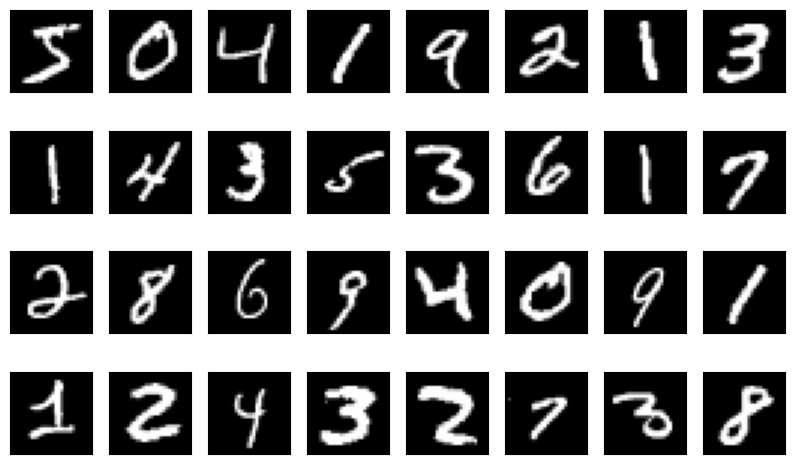

In [5]:
def plot_some_samples(some_samples):
    fig = plt.figure(figsize=(10, 6))
    for j in range(some_samples.shape[0]):
        ax = fig.add_subplot(4, 8, j+1)
        ax.imshow(some_samples[j,:,:,0], cmap='gray')
        plt.xticks([]), plt.yticks([])
    plt.show()
    
plot_some_samples(train_x[:32, ...])

### Aumento: adición de muestras de clase "fondo

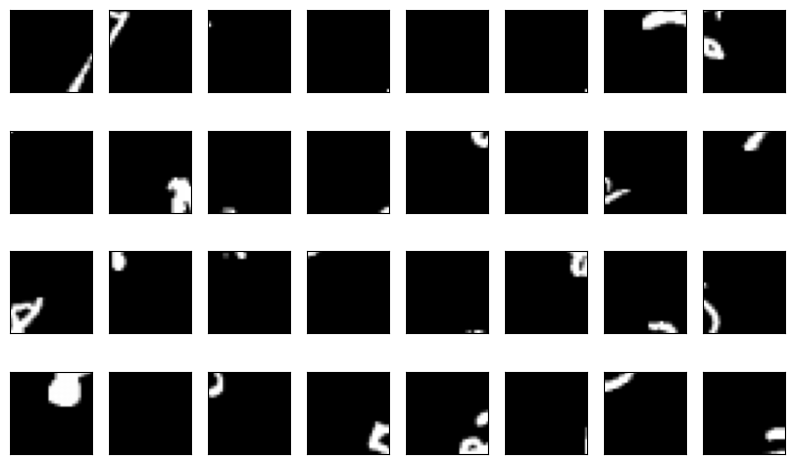

In [6]:
bg_samples = 100000 

bg_train_x = np.zeros((bg_samples, 28, 28, 1), dtype=np.float32)
bg_train_y = np.ones((bg_samples,), dtype=np.int32)*10 

src_idxs = random.choices(range(train_x.shape[0]), k=bg_samples)

sh = train_x.shape[1]
sw = train_x.shape[2]
for i in range(bg_samples):
    dh = random.randint(sh//4, 3*sh//4) * random.choice([-1, 1])
    dw = random.randint(sw//4, 3*sw//4) * random.choice([-1, 1])

    sample = train_x[src_idxs[i], ...]

    bg_train_x[i, max(-dh,0):min(sh-dh,sh), max(-dw,0):min(sw-dw, sw), :] = \
        sample[max( dh,0):min(sh+dh,sh), max( dw,0):min(sw+dw, sw), :]

plot_some_samples(bg_train_x[:32, ...])

### Aumento: añadir muestras de las clases de dígitos originales

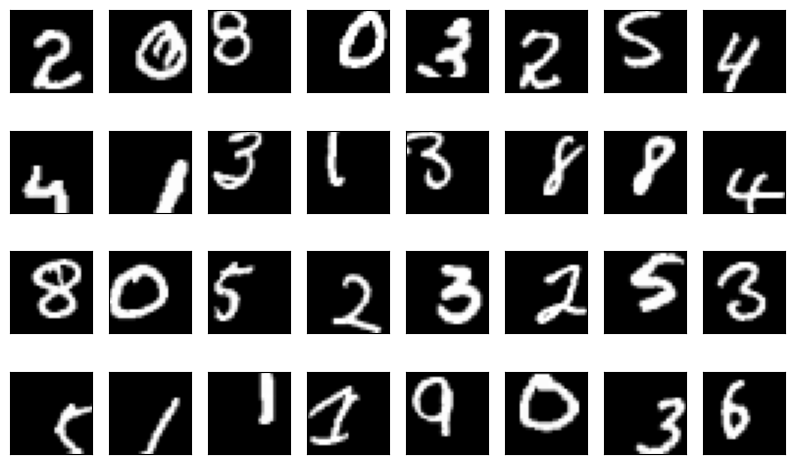

In [7]:
sh_samples = 50000 

sh_train_x = np.zeros((sh_samples, 28, 28, 1), dtype=np.float32)
sh_train_y = np.zeros((sh_samples,), dtype=np.int32)

src_idxs = random.sample(range(train_x.shape[0]), sh_samples)

sh = train_x.shape[1]
sw = train_x.shape[2]
for i in range(sh_samples):
    dh = random.randint(0, sh//4) * random.choice([-1, 1])
    dw = random.randint(0, sw//4) * random.choice([-1, 1])

    sample = train_x[src_idxs[i], ...]

    sh_train_x[i, max(-dh,0):min(sh-dh,sh), max(-dw,0):min(sw-dw, sw), :] = \
        sample[max( dh,0):min(sh+dh,sh), max( dw,0):min(sw+dw, sw), :]
    sh_train_y[i] = train_y[src_idxs[i]]

plot_some_samples(sh_train_x[:32, ...])

In [8]:
train_x = np.concatenate((train_x, bg_train_x, sh_train_x), axis=0)
train_y = np.concatenate((train_y, bg_train_y, sh_train_y), axis=0)

In [9]:
NUM_CLASSES = 11
NUM_EPOCHS = 3
BATCH_SIZE = 64

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Conv2D(128, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
])

In [11]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [12]:
model.fit(train_x, train_y, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/3


3282/3282 [==============================] - 464s 141ms/step - loss: 0.0971 - accuracy: 0.9700
Epoch 2/3
3282/3282 [==============================] - 463s 141ms/step - loss: 0.0376 - accuracy: 0.9879
Epoch 3/3
3282/3282 [==============================] - 454s 138ms/step - loss: 0.0268 - accuracy: 0.9910


In [13]:
model.evaluate(test_x, test_y)

313/313 [==============================] - 7s 21ms/step - loss: 0.0224 - accuracy: 0.9931


[0.022398456931114197, 0.9930999875068665]

# Localización débil con FCN

La conversión a FCN se realizará en dos pasos: primero crearemos una arquitectura FCN objetivo con parámetros (pesos) aleatorios y, a continuación, copiaremos los parámetros (pesos) correspondientes del clasificador a FCN.

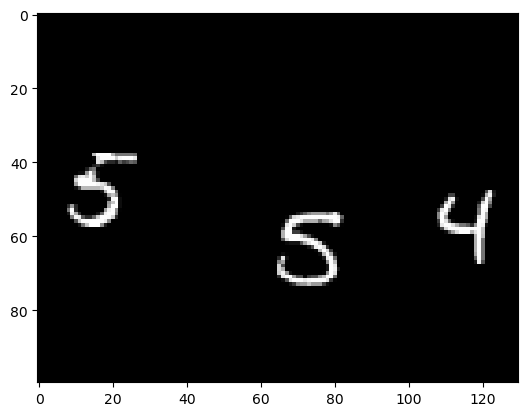

In [20]:
if True: # Generar una imagen aleatoria
    
    img = np.zeros((100, 130, 1), dtype=np.float32)
    def add_digit(img, digit):
        ofs = (random.randint(0, img.shape[0]-digit.shape[0]),
               random.randint(0, img.shape[1]-digit.shape[1]))
        img[ofs[0]:ofs[0]+digit.shape[0], ofs[1]:ofs[1]+digit.shape[1], :] += digit
        img = np.clip(img, 0.0, 1.0)
        return img
    for _ in range(3):
        digit = test_x[random.randint(0, test_x.shape[0])]
        img = add_digit(img, digit)
    
else: # Cargar la imagen terminada 'digits.png'
    
    INPUT_IMAGE_FPTAH = 'digits.png'
    img = imageio.imread(INPUT_IMAGE_FPTAH, pilmode="RGB")
    img = img.astype(np.float32)/255.
    img = np.mean(img, axis=2, keepdims=True)
    
# Convertir la imagen de entrada a RGB 
# (para su visualización y posterior mezcla con un mapa térmico de color)
img_clr = np.tile(img, (1, 1, 3))
_=plt.imshow(img_clr)

### Creación del modelo FCN

In [21]:
model_fcn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Conv2D(128, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Conv2D(256, (7, 7), activation='relu', padding='valid'),        #!!!
    tf.keras.layers.Conv2D(NUM_CLASSES, (1, 1), activation='softmax', padding='valid'),   #!!!
])

model_fcn.build((None, None, None, 1))

### Lista de capas del modelo fuente

In [22]:
for idx, layer in enumerate(model.layers):
    print('{} ==> {}'.format(idx, layer))

0 ==> <keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000019081EC25D0>
1 ==> <keras.src.layers.convolutional.conv2d.Conv2D object at 0x00000190820EECD0>
2 ==> <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001908277A050>
3 ==> <keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000019084964910>
4 ==> <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001908494BA10>
5 ==> <keras.src.layers.reshaping.flatten.Flatten object at 0x0000019082027C90>
6 ==> <keras.src.layers.core.dense.Dense object at 0x0000019084963050>
7 ==> <keras.src.layers.core.dense.Dense object at 0x0000019081FD8750>


## Lista de capas del nuevo modelo FCN

In [23]:
for idx, layer in enumerate(model_fcn.layers):
    print('{} ==> {}'.format(idx, layer))

0 ==> <keras.src.layers.convolutional.conv2d.Conv2D object at 0x00000190878CAC50>
1 ==> <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001908F4A2F90>
2 ==> <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001908501BCD0>
3 ==> <keras.src.layers.convolutional.conv2d.Conv2D object at 0x00000190878FC990>
4 ==> <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000019087895DD0>
5 ==> <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001908F4AE310>
6 ==> <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001908F476BD0>


### Copiar parámetros del modelo original

Cada una de estas capas tiene los tensores `kernel` y `bias`, que representan los pesos y el sesgo respectivamente. En el caso de una capa totalmente conectada, los pesos son una matriz, y en el caso de una capa convolucional son un tensor de cuatro dimensiones con núcleos convolucionales.

In [24]:
model_fcn.layers[0].kernel = model.layers[0].kernel
model_fcn.layers[0].bias = model.layers[0].bias
model_fcn.layers[1].kernel = model.layers[1].kernel
model_fcn.layers[1].bias = model.layers[1].bias
model_fcn.layers[3].kernel = model.layers[3].kernel
model_fcn.layers[3].bias = model.layers[3].bias
model_fcn.layers[5].kernel = tf.reshape(model.layers[6].kernel, (7, 7, 128, 256))
model_fcn.layers[5].bias = model.layers[6].bias
model_fcn.layers[6].kernel = tf.reshape(model.layers[7].kernel, (1, 1, 256, 11))
model_fcn.layers[6].bias = model.layers[7].bias

In [25]:
heatmaps = model_fcn.predict(img[None, ...])[0, ...]

1/1 [==============================] - 0s 188ms/step


### Ampliación de los mapas de calor

In [26]:
from skimage.transform import resize

rec_field = (28, 28) # Campo receptivo del modelo FCN

# Primero escalamos los mapas de calor
heatmaps = resize(heatmaps, (
        img.shape[0]-rec_field[0]+1, 
        img.shape[1]-rec_field[1]+1), 
    order=3, mode='reflect', anti_aliasing=True)

# Luego hacemos el relleno
diff = (img.shape[0]-heatmaps.shape[0],
        img.shape[1]-heatmaps.shape[1],)
heatmaps = np.pad(heatmaps, (
    (diff[0]//2,diff[0]-diff[0]//2),
    (diff[1]//2,diff[1]-diff[1]//2),
    (0, 0)
), 'constant')

### Visualización de mapas de calor para diferentes clases

Heatmap for class: 0


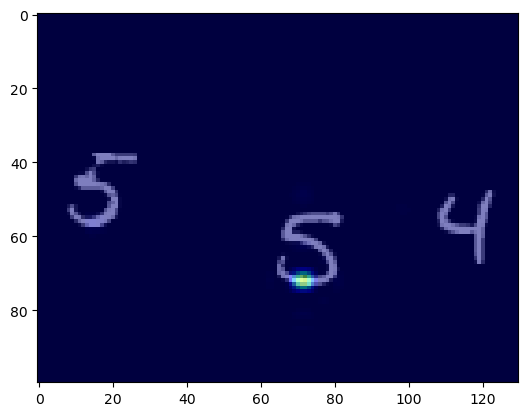

Heatmap for class: 1


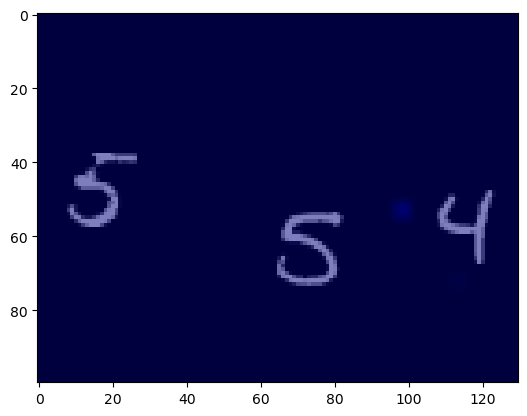

Heatmap for class: 2


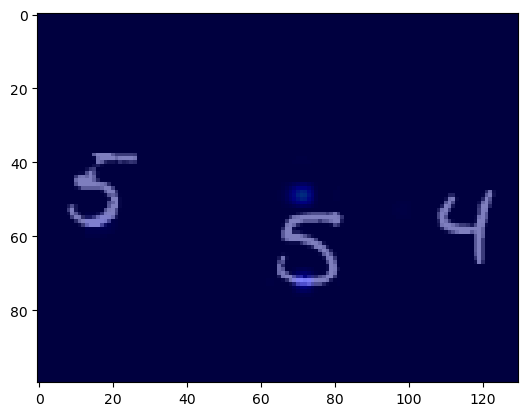

Heatmap for class: 3


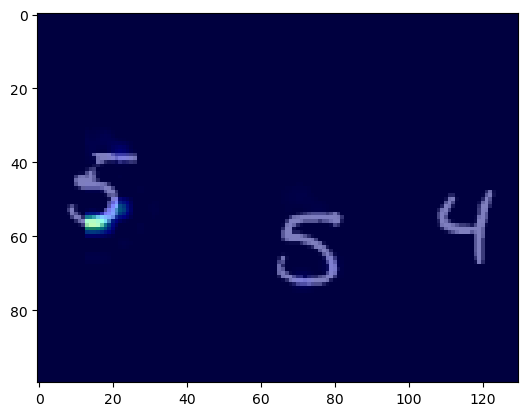

Heatmap for class: 4


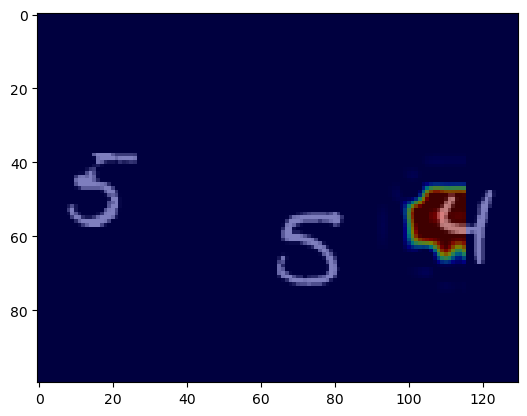

Heatmap for class: 5


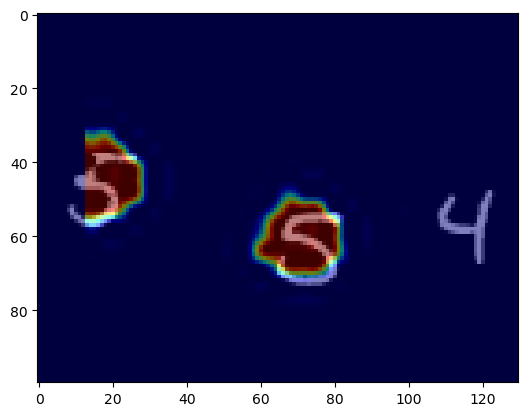

Heatmap for class: 6


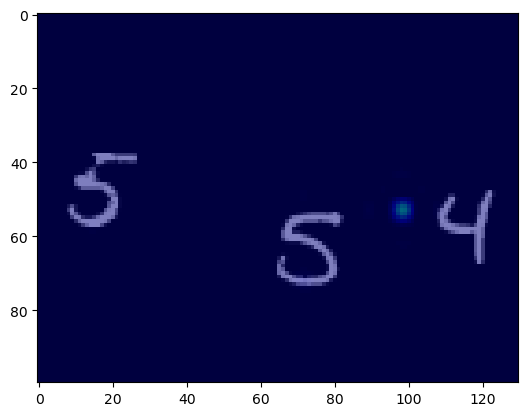

Heatmap for class: 7


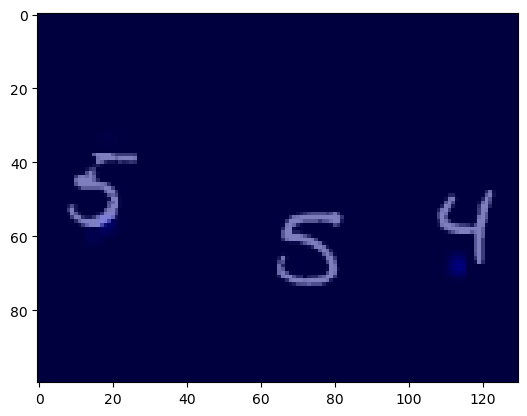

Heatmap for class: 8


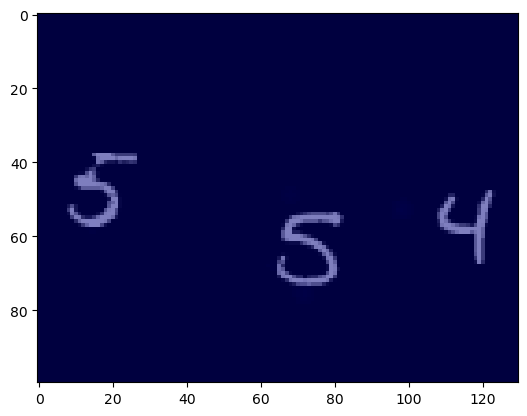

Heatmap for class: 9


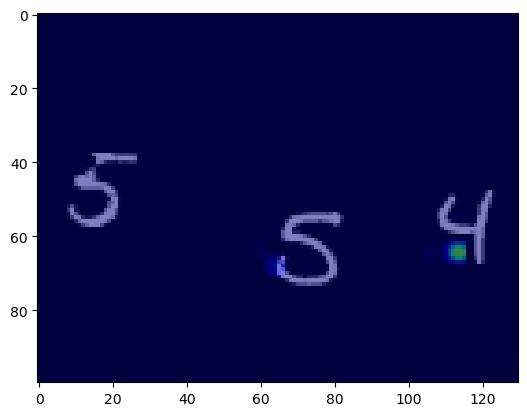

Heatmap for class: 10


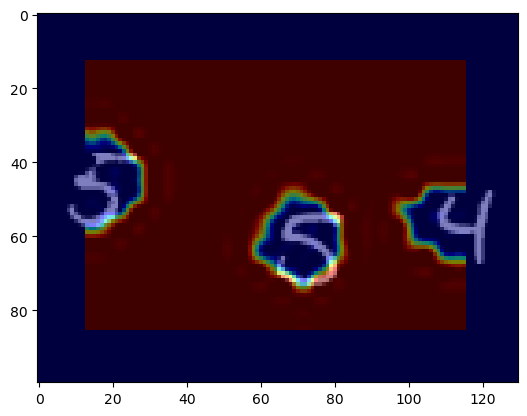

In [27]:
for clss in range(11):
    heatmap = heatmaps[..., clss]
    heatmap_clr = plt.get_cmap('jet')(heatmap)[..., :3]
    print('Heatmap for class:', clss)
    plt.imshow(img_clr*0.5 + heatmap_clr*0.5)    
    plt.show()